# Technical Test Pythae

To run this notebook you will need a Python version >=3.8

## Preliminaries: Setup environnement & Data

In [26]:
#%pip install pythae torchvision torch torchsummary matplotlib

In [ ]:
import matplotlib.pyplot as plt

def plot_grid(mat_data, grid_size=5):

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout()

In [27]:
import torch
from torch.utils.data import Dataset
from pythae.data.datasets import DatasetOutput


class MNIST(Dataset):
    def __init__(self, data):
        self.data = data #.type(torch.float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        return DatasetOutput(data=x)

In [28]:
import torch
from torch.utils.data import Dataset, ConcatDataset
from pythae.data.datasets import DatasetOutput
from torchvision import datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [29]:
import random

def sample_indices(vector, k, seed=None):
    # # Example usage:
    # vector = torch.tensor([0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 3])  # Example tensor with 4 labels
    # k = 3  # Number of points to sample from each label
    # seed = 42  # Seed for reproducibility
    # sampled_indices = sample_indices(vector, k, seed)
    # print("Sampled indices:", sampled_indices)

    if seed is not None:
        random.seed(seed)

    indices = []
    label_dict = {}

    # Group indices by label
    for i, label in enumerate(vector):
        label = label.item() if torch.is_tensor(label) else label
        if label not in label_dict:
            label_dict[label] = [i]
        else:
            label_dict[label].append(i)

    # Sample k points from each label
    for label, label_indices in label_dict.items():
        sampled_indices = random.sample(label_indices, min(k, len(label_indices)))
        indices.extend(sampled_indices)

    random.shuffle(indices)

    return indices

In [30]:
train_indeces = sample_indices(mnist_trainset.targets, k=20, seed=42)

remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=10, seed=42)

In [31]:
train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.
print(train_dataset.shape, eval_dataset.shape)

torch.Size([200, 1, 28, 28]) torch.Size([100, 1, 28, 28])


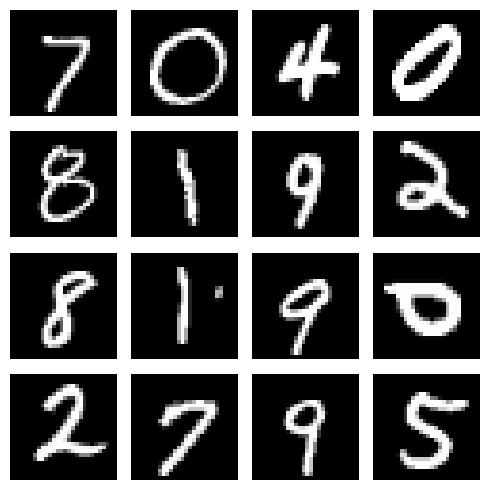

In [33]:
import matplotlib.pyplot as plt


_, ax = plt.subplots(nrows=4, ncols=4, figsize=(5,5))

for i in range(4):
    for j in range(4):
        ax[i][j].imshow(train_dataset[i*4+j].movedim(0, 2), cmap='gray')
        ax[i][j].axis('off')
plt.tight_layout()

## Step 1: Training a VAE with Pythae

In [34]:
from pythae.models import RHVAEConfig, RHVAE
from pythae.models.nn.benchmarks.mnist import *

model_config = RHVAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=8
)

model = RHVAE(
    model_config=model_config,
    encoder=Encoder_ResNet_VAE_MNIST(model_config),
    decoder=Decoder_ResNet_AE_MNIST(model_config)
)

In [35]:
from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=35,
    learning_rate=1e-3,
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
)

# trainer = BaseTrainer(
#     model=model,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     training_config=training_config
# )

# trainer.train()

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)


pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset
)
    

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created experiments/RHVAE_training_2024-04-09_11-58-11. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 10
 - per_device_train_batch_size: 100
 - per_device_eval_batch_size: 100
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.003
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !



Training of epoch 1/10:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 1/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.462
Eval loss: 67.4704
--------------------------------------------------------------------------


Training of epoch 2/10:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 2/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 142.4732
Eval loss: 74.4083
--------------------------------------------------------------------------


Training of epoch 3/10:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 3/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.4143
Eval loss: 55.1775
--------------------------------------------------------------------------


Training of epoch 4/10:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 4/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 78.9035
Eval loss: 93.1562
--------------------------------------------------------------------------


Training of epoch 5/10:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 5/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 81.0916
Eval loss: 73.8212
--------------------------------------------------------------------------


Training of epoch 6/10:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 6/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 70.3639
Eval loss: 72.1337
--------------------------------------------------------------------------


Training of epoch 7/10:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 7/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 68.9536
Eval loss: 67.0484
--------------------------------------------------------------------------


Training of epoch 8/10:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 8/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.203
Eval loss: 62.1272
--------------------------------------------------------------------------


Training of epoch 9/10:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 9/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.2451
Eval loss: 57.315
--------------------------------------------------------------------------


Training of epoch 10/10:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 10/10:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 56.03
Eval loss: 54.2155
--------------------------------------------------------------------------
Training ended!
Saved final model in experiments/RHVAE_training_2024-04-09_11-58-11/final_model


## Step 2: Generating synthetic images with PythAE

In [36]:
from pythae.models import AutoModel

import glob

# trained_model = AutoModel.load_from_folder(
#     glob.glob('experiments/*/final_model')[0]
# )

trained_model = model

### Normal Sampler

In [37]:
from pythae.samplers import NormalSampler


sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

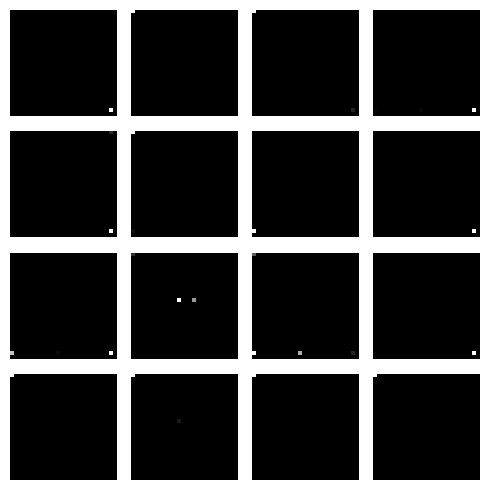

### Gaussian Mixture Model Sampler

In [39]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=10
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=16
)

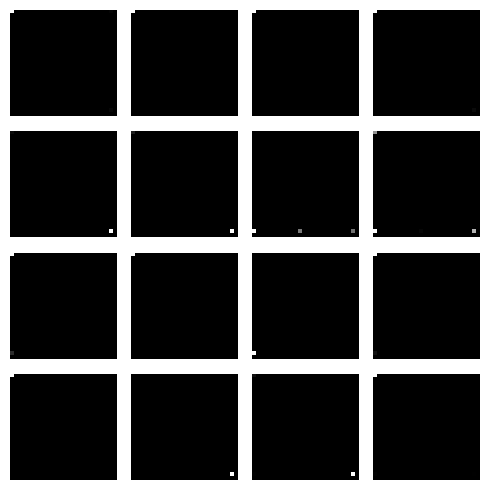

In [40]:
import matplotlib.pyplot as plt


_, ax = plt.subplots(nrows=4, ncols=4, figsize=(5,5))

for i in range(4):
    for j in range(4):
        ax[i][j].imshow(gmm_gen_data[i*4+j].movedim(0, 2), cmap='gray')
        ax[i][j].axis('off')
plt.tight_layout()

### RHVAE Sampler

In [41]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig


rh_sampler_config = RHVAESamplerConfig(
)

rh_sampler = RHVAESampler(
    sampler_config=None,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=16
)

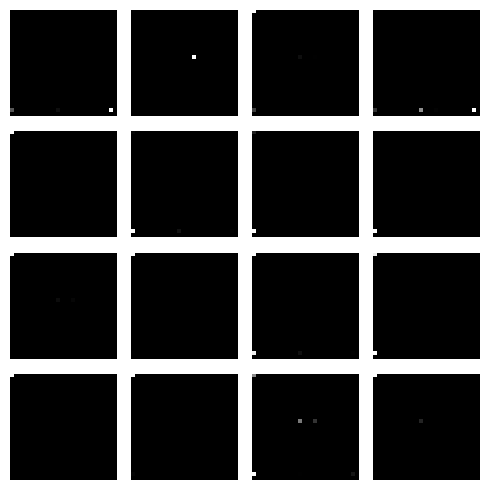

In [42]:
import matplotlib.pyplot as plt


_, ax = plt.subplots(nrows=4, ncols=4, figsize=(5,5))

for i in range(4):
    for j in range(4):
        ax[i][j].imshow(rh_gen_data[i*4+j].movedim(0, 2), cmap='gray')
        ax[i][j].axis('off')
plt.tight_layout()

In [43]:
rh_gen_data.shape

torch.Size([16, 1, 28, 28])

In [51]:
#combined_dataset = ConcatDataset([train_dataset, rh_gen_data])
combined_dataset = torch.cat((train_dataset, rh_gen_data), 0)
combined_dataset = combined_dataset[torch.randperm(combined_dataset.size()[0])]
combined_dataset.shape

torch.Size([216, 1, 28, 28])